#### Self-contained notebook.

Demonstrating that the bounds for dominated Hessian are incorrect.

In [1]:
using Plots
using StatsBase
using Distributions

In [5]:
ENV["PYTHON"]=""
Pkg.build("PyCall")

INFO: Building Conda
INFO: Building PyCall
Info: Using the Python distribution in the Conda package by default.
To use a different Python version, set ENV["PYTHON"]="pythoncommand" and re-run Pkg.build("PyCall").


Solving environment: ...working... done


conda-4.5.10         |  1.0 MB | ########## | 100% 
certifi-2018.8.13    |  139 KB | ########## | 100% 
openssl-1.0.2p       |  3.5 MB | #########7 |  98% 


## Package Plan ##

  environment location: /home/deborshee/.julia/v0.6/Conda/deps/usr

  added / updated specs: 
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.5.10               |           py27_0         1.0 MB
    certifi-2018.8.13          |           py27_0         139 KB
    openssl-1.0.2p             |       h14c3975_0         3.5 MB
    ------------------------------------------------------------
                                           Total:         4.6 MB

The following packages will be UPDATED:

    certifi: 2018.4.16-py27_0  --> 2018.8.13-py27_0 
    conda:   4.5.9-py27_0      --> 4.5.10-py27_0    
    openssl: 1.0.2o-h14c3975_1 --> 1.0.2p-h14c3975_0


Preparing transaction: ...working... 

openssl-1.0.2p       |  3.5 MB | ########## | 100% 


done
Verifying transaction: ...working... done
Executing transaction: ...working... done


Info: PyCall is using /home/deborshee/.julia/v0.6/Conda/deps/usr/bin/python (Python 2.7.15) at /home/deborshee/.julia/v0.6/Conda/deps/usr/bin/python, libpython = /home/deborshee/.julia/v0.6/Conda/deps/usr/lib/libpython2.7
Info: /home/deborshee/.julia/v0.6/PyCall/deps/deps.jl has not changed
Info: /home/deborshee/.julia/v0.6/PyCall/deps/PYTHON has not changed


In [6]:
using PyPlot 

In [2]:
function logistic_data(Nobs, beta) 
    X = rand(3,Nobs)/10
    X[2,1:5] += 10
    X[2,6:20] -= 5
    X[2,21:23] -= 10
    X[2,24:30] += 5
    y = [rand(1)[1] < 1/(1 + exp(-dot(beta,X[:,i]))) for i in 1:Nobs] .+ 0
    return X, y
end

logistic_data (generic function with 1 method)

In [3]:
beta = [1. 1. 1.]
X, y = logistic_data(10^3, beta);

### Zig-zag with dominated Hessian 

* Section 3.3 of https://arxiv.org/pdf/1607.03188v2.pdf 

In [4]:
pos(x) = max(x, 0)

function derivative_full(X, y, xi, k)  # derivative for full dataset
    d, Nobs = size(X)
    xi = reshape(xi,1,d)
    sum(X[k,:].*reshape( exp.(xi*X)./(1+exp.(xi*X)), Nobs,) - y.*X[k,:])
end

function get_event_time(ai, bi)     # for linear bounds
    # this assumed that bi is positive 
    u = rand(1)[1]
    if ai >= 0 
        return (-ai + sqrt(ai^2 - 2*bi*log(u))) / bi
    else
        return -ai/bi + sqrt(-2*log(u)/bi)
    end
end

get_event_time (generic function with 1 method)

In [5]:
function ZZ_log_dom_Hess(X, y, max_attempts, beta_0) 

    # define and initialise stuff:
    d, Nobs = size(X) 
    t, switches, bouncing_times = 0, 0, []
    push!(bouncing_times, 0.)
    skeleton_points, theta = beta_0, ones(d)
    xi = copy(beta_0)
    
    Q = X*X'/4    
    a = [theta[i]*derivative_full(X, y, xi, i) for i in 1:d]
    b = [sqrt(d)*norm(Q[:,i]) for i in 1:d]
    
    # run sampler:
    for attempt in 1:max_attempts
        event_times = [get_event_time(a[i], b[i]) for i in 1:d]        
        tau, i0 = findmin(event_times)   
        t += tau 
        xi_initial = copy(xi) 
        xi += reshape(tau*theta, d, 1)
        switching_probability = pos(theta[i0]*derivative_full(X, y, xi, i0)) / pos(a[i0] + b[i0]*tau)
        if switching_probability > 1 
            print("Error, switching probabity is larger than 1. \n")
            print("switching rate = ", pos(theta[i0]*derivative_full(X, y, xi, i0)), 
                  ", bound = ", pos(a[i0] + b[i0]*tau), "\n")
            print("i0 = ", i0, ", tau = ", tau, ", xi_initial = ", xi_initial, 
                  ", theta = ", theta, ", attempt = ", attempt, "\n")
            break;
        else 
            if rand(1)[1] <= switching_probability 
                theta[i0] *= -1
                switches += 1
                skeleton_points = hcat(skeleton_points, xi)
                push!(bouncing_times, t)
            end
        end
        a = [theta[i]*derivative_full(X, y, xi, i) for i in 1:d]
    end
    print(signif(100*switches/max_attempts,2),"% of switches accepted \n")
    return hcat(skeleton_points, xi), push!(bouncing_times, t);
end;

In [6]:
beta_0 = ones(length(beta))
start = time()
skeleton_full, bouncing_times_full = ZZ_log_dom_Hess(X, y, 10^5, beta_0)
print(round((time()-start)/60,1), " minutes to run")

Error, switching probabity is larger than 1. 
switching rate = 1.2617181518527891, bound = 1.2581773895055517
i0 = 1, tau = 0.023774643997347546, xi_initial = [1.40824; 0.91952; -2.0164], theta = [-1.0, -1.0, -1.0], attempt = 746
0.087% of switches accepted 
0.0 minutes to run

#### Investigate more:

In [8]:
i0 = 1
tau = 0.023774643997347546
xi_initial = [1.40824; 0.91952; -2.0164]
theta = [-1.0, -1.0, -1.0]
xi_new = xi_initial + reshape(tau*theta, 3, 1);

In [10]:
Q = X*X'/4
aa = [theta[i]*derivative_full(X, y, xi_initial, i) for i in 1:3] 
bb = [sqrt(3)*norm(Q[:,i]) for i in 1:3];

In [11]:
aa + bb*tau

3-element Array{Float64,1}:
  1.25818
 10.8259 
  1.65866

In [12]:
[theta[i]*derivative_full(X, y, xi_new, i) for i in 1:3] 

3-element Array{Float64,1}:
  1.26172
 -2.89693
  1.65857

#### How is the bound smaller than the rate?!

In [16]:
t_list = (101:300)/10^4
rts = [theta[1]*derivative_full(X, y, xi_initial+reshape(t_list[t]*theta,3,1), i0) for t in 1:size(t_list)[1]]
bds = [aa[i0] + t_list[t]*bb[i0] for t in 1:size(t_list)[1]];

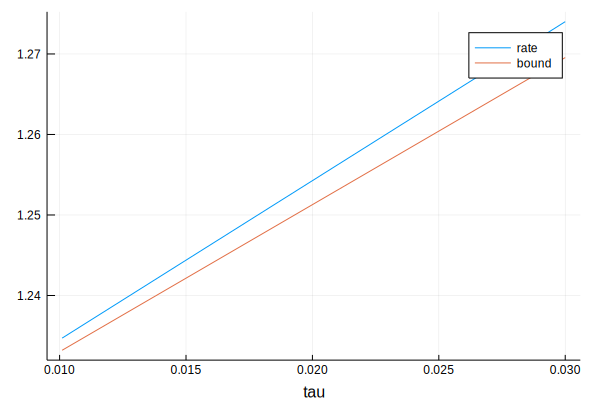

In [22]:
plot(t_list, rts, label="rate", xlabel="tau")
plot!(t_list, bds, label="bound")

It seems like there is a problem with the bounds. Taking $b_i = d \| Q \, e_i \|$ instead of $b_i = \sqrt{d} \| Q \, e_i \|$, $i = 1, \ldots, d$ **seems** to fix the problem.

In [13]:
using PyPlot
x = linspace(0,2*pi,1000); y = sin.(3 * x + 4 * cos.(2 * x));
plot(x, y, color="red", linewidth=2.0, linestyle="--")
title("A sinusoidally modulated sinusoid")

LoadError: [91mUndefVarError: plot not defined[39m